<a href="https://colab.research.google.com/github/GUILLENJV/Sistema-de-Recomendacion-Redes-Neuronales/blob/master/Informe_Num_40_Sistemas_de_recomendaci%C3%B3n_modernos_con_redes_neuronales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sistemas de recomendación modernos con redes neuronales

Los sistemas de recomendación son modelos que predicen las preferencias de los usuarios sobre múltiples productos. Se utilizan en una variedad de áreas, como servicios de video y música, comercio electrónico y plataformas de redes sociales.

Los métodos más comunes aprovechan las características del producto (basado en el contenido), la similitud del usuario (filtrado colaborativo), la información personal (basada en el conocimiento). Sin embargo, con la creciente popularidad de las redes neuronales, las empresas han comenzado a experimentar con nuevos sistemas de recomendación híbridos que los combinan a todos.

Usaré el conjunto de datos de MovieLens que contiene miles de películas calificadas por cientos de usuarios, creado por GroupLens Research.

En este artículo, mostraré cómo construir sistemas de recomendación modernos con redes neuronales, usando Python y TensorFlow.

In [ ]:
import warnings
warnings.filterwarnings("ignore")

## for data
import pandas as pd
import numpy as np
import re
from datetime import datetime

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## for machine learning
from sklearn import metrics, preprocessing

## for deep learning
from tensorflow.keras import models, layers, utils  #(2.6.0)

In [ ]:
# Products
dtf_products = pd.read_excel("data_movies.xlsx", sheet_name="products")

In [ ]:
dtf_products.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


En la tabla de productos, cada fila representa un artículo y las dos columnas de la derecha contienen sus características, que son estáticas (puedes verlas como metadatos de películas). Leamos los datos del usuario:

Cada fila de esta otra tabla es un par usuario-producto y muestra la valoración que los usuarios han dado a los productos, que es la variable objetivo . Obviamente, no todos los usuarios han visto todos los productos. De hecho, por eso necesitamos Sistemas de Recomendación. Tienen que predecir qué tipo de calificación le daría un usuario a un nuevo producto, y si la calificación pronosticada es alta/positiva, entonces se recomienda. Además, aquí también hay información sobre el contexto de la variable objetivo (cuándo el usuario dio la calificación).

In [ ]:
# Products
dtf_products = pd.read_excel("data_movies.xlsx", sheet_name="products")

dtf_products = dtf_products[~dtf_products["genres"].isna()]
dtf_products["product"] = range(0,len(dtf_products))
dtf_products["name"] = dtf_products["title"].apply(lambda x: re.sub("[\(\[].*?[\)\]]", "", x).strip())
dtf_products["date"] = dtf_products["title"].apply(lambda x: int(x.split("(")[-1].replace(")","").strip()) 
                                                             if "(" in x else np.nan)

## add features
dtf_products["date"] = dtf_products["date"].fillna(9999)
dtf_products["old"] = dtf_products["date"].apply(lambda x: 1 if x < 2000 else 0)

dtf_products

,movieId,title,genres,product,name,date,old
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,Toy Story,1995.0,1
1,2,Jumanji (1995),Adventure|Children|Fantasy,1,Jumanji,1995.0,1
2,3,Grumpier Old Men (1995),Comedy|Romance,2,Grumpier Old Men,1995.0,1
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,3,Waiting to Exhale,1995.0,1
4,5,Father of the Bride Part II (1995),Comedy,4,Father of the Bride Part II,1995.0,1
...,...,...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,9736,Black Butler: Book of the Atlantic,2017.0,0
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,9737,No Game No Life: Zero,2017.0,0
9739,193585,Flint (2017),Drama,9738,Flint,2017.0,0
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,9739,Bungo Stray Dogs: Dead Apple,2018.0,0


In [ ]:
# Users
dtf_users = pd.read_excel("data_movies.xlsx", sheet_name="users").head(10000)

dtf_users["user"] = dtf_users["userId"].apply(lambda x: x-1)

dtf_users["timestamp"] = dtf_users["timestamp"].apply(lambda x: datetime.fromtimestamp(x))
dtf_users["daytime"] = dtf_users["timestamp"].apply(lambda x: 1 if 6<int(x.strftime("%H"))<20 else 0)
dtf_users["weekend"] = dtf_users["timestamp"].apply(lambda x: 1 if x.weekday() in [5,6] else 0)

dtf_users = dtf_users.merge(dtf_products[["movieId","product"]], how="left")
dtf_users = dtf_users.rename(columns={"rating":"y"})

dtf_users

,userId,movieId,y,timestamp,user,daytime,weekend,product
0,1,1,4.0,2000-07-30 18:45:03,0,1,1,0
1,1,3,4.0,2000-07-30 18:20:47,0,1,1,2
2,1,6,4.0,2000-07-30 18:37:04,0,1,1,5
3,1,47,5.0,2000-07-30 19:03:35,0,1,1,43
4,1,50,5.0,2000-07-30 18:48:51,0,1,1,46
...,...,...,...,...,...,...,...,...
9995,66,248,3.0,2005-04-11 03:41:32,65,0,0,212
9996,66,255,0.5,2005-04-11 03:07:20,65,0,0,219
9997,66,260,2.5,2004-08-29 02:45:50,65,0,1,224
9998,66,272,3.5,2005-04-11 03:31:59,65,0,0,234


In [ ]:
# select only useful columns
dtf_products = dtf_products[["product","name","old","genres"]].set_index("product")
dtf_products.head()

,name,old,genres
product,,,
0,Toy Story,1,Adventure|Animation|Children|Comedy|Fantasy
1,Jumanji,1,Adventure|Children|Fantasy
2,Grumpier Old Men,1,Comedy|Romance
3,Waiting to Exhale,1,Comedy|Drama|Romance
4,Father of the Bride Part II,1,Comedy


Tenga en cuenta que extraje 2 variables de contexto de la columna de marca de tiempo: día y fin de semana . Los guardaré en un marco de datos, ya que podríamos necesitarlos más adelante.

In [ ]:
# extract context
dtf_context = dtf_users[["user","product","daytime","weekend"]]
dtf_context.head()

,user,product,daytime,weekend
0,0,0,1,1
1,0,2,1,1
2,0,5,1,1
3,0,43,1,1
4,0,46,1,1


In [ ]:
dtf_users = dtf_users[["user","product","y"]]
dtf_users.head()

,user,product,y
0,0,0,4.0
1,0,2,4.0
2,0,5,4.0
3,0,43,5.0
4,0,46,5.0


# 1 - Data Analysis

Con respecto a los productos, el siguiente paso es crear la matriz Productos-Características :

In [ ]:
tags = [i.split("|") for i in dtf_products["genres"].unique()]
columns = list(set([i for lst in tags for i in lst]))
columns.remove('(no genres listed)')
print(columns)

['Crime', 'Animation', 'Romance', 'Comedy', 'Action', 'IMAX', 'Thriller', 'Musical', 'Fantasy', 'Sci-Fi', 'Children', 'Western', 'Horror', 'War', 'Adventure', 'Mystery', 'Film-Noir', 'Drama', 'Documentary']


In [ ]:
for col in columns:
    dtf_products[col] = dtf_products["genres"].apply(lambda x: 1 if col in x else 0)
dtf_products.head()

,name,old,genres,Crime,Animation,Romance,Comedy,Action,IMAX,Thriller,...,Sci-Fi,Children,Western,Horror,War,Adventure,Mystery,Film-Noir,Drama,Documentary
product,,,,,,,,,,,,,,,,,,,,,
0,Toy Story,1,Adventure|Animation|Children|Comedy|Fantasy,0,1,0,1,0,0,0,...,0,1,0,0,0,1,0,0,0,0
1,Jumanji,1,Adventure|Children|Fantasy,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
2,Grumpier Old Men,1,Comedy|Romance,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Waiting to Exhale,1,Comedy|Drama|Romance,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,Father of the Bride Part II,1,Comedy,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


La matriz es escasa ya que la mayoría de los productos no tienen todas las características. Vamos a visualizarlo para entender mejor la situación.

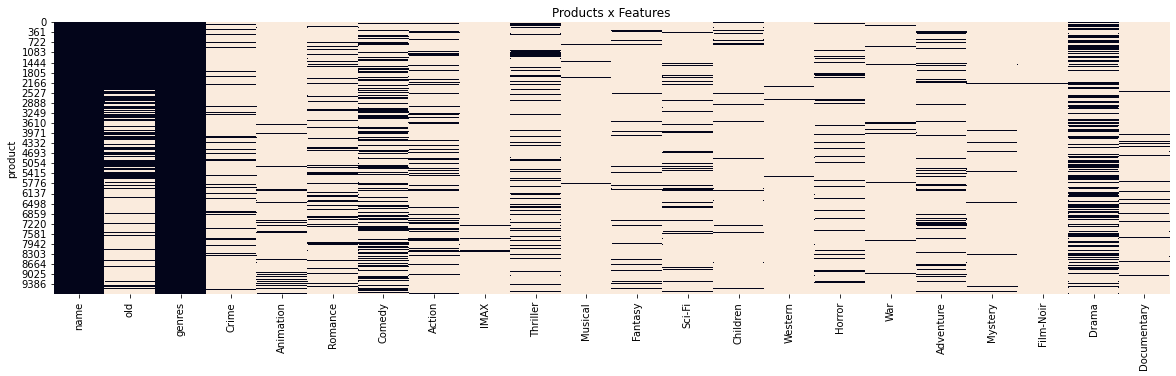

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(dtf_products==0, vmin=0, vmax=1, cbar=False, ax=ax).set_title("Products x Features")
plt.show()

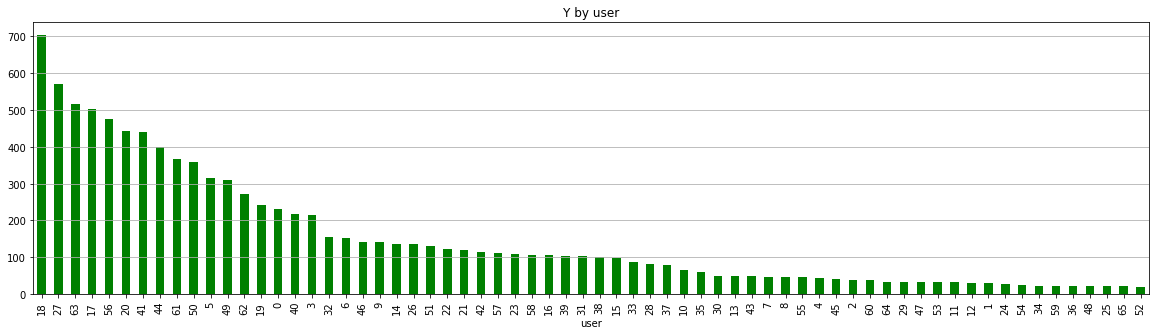

In [ ]:
dtf_users.groupby("user").count()["product"].sort_values(ascending=False).plot(
    kind="bar", color="green", title="Y by user", figsize=(20,5)).grid(axis='y')

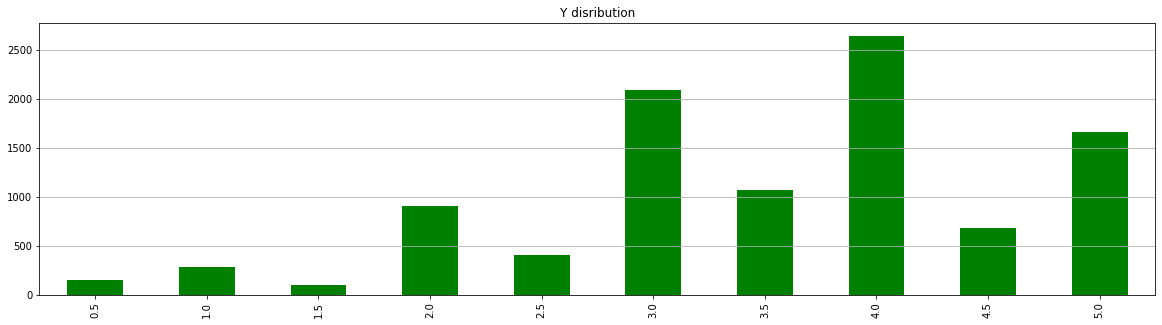

In [ ]:
dtf_users["y"].value_counts().sort_index().plot(kind="bar", color="green", title="Y disribution", 
                                                figsize=(20,5)).grid(axis='y')
plt.show()

In [ ]:
tmp = dtf_users.copy()
dtf_users = tmp.pivot_table(index="user", columns="product", values="y")
missing_cols = list(set(dtf_products.index) - set(dtf_users.columns))
for col in missing_cols:
    dtf_users[col] = np.nan
dtf_users = dtf_users[sorted(dtf_users.columns)]
dtf_users

product,0,1,2,3,4,5,6,7,8,9,...,9731,9732,9733,9734,9735,9736,9737,9738,9739,9740
user,,,,,,,,,,,,,,,,,,,,,
0,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,NaN,4.0,NaN,NaN,NaN,4.5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,4.0,NaN,3.5,NaN,NaN,4.5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


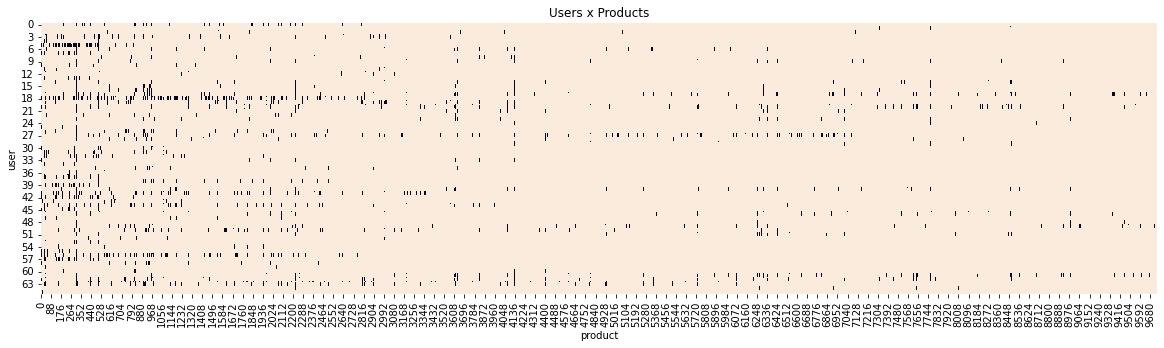

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(dtf_users.isnull(), vmin=0, vmax=1, cbar=False, ax=ax).set_title("Users x Products")
plt.show()

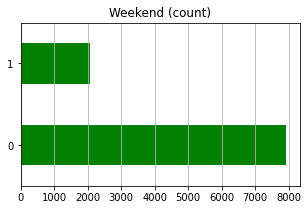

In [ ]:
dtf_context["weekend"].value_counts().plot(kind="barh", color="green", title="Weekend (count)", 
                                         figsize=(5,3)).grid(axis='x')
plt.show()

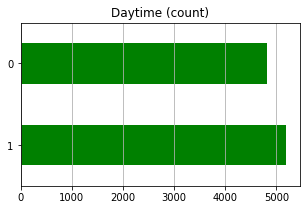

In [ ]:
dtf_context["daytime"].value_counts().plot(kind="barh", color="green", title="Daytime (count)", 
                                         figsize=(5,3)).grid(axis='x')
plt.show()

# 2 - Preprocessing
* Scaling
* Partitioning

El último paso antes de profundizar en los modelos es el Preprocesamiento . Dado que nos ocuparemos de las redes neuronales, siempre es una buena práctica escalar los datos.

### Scaling

In [ ]:
dtf_users = pd.DataFrame(preprocessing.MinMaxScaler(feature_range=(0.5,1)).fit_transform(dtf_users.values), 
                         columns=dtf_users.columns, index=dtf_users.index)
dtf_users

product,0,1,2,3,4,5,6,7,8,9,...,9731,9732,9733,9734,9735,9736,9737,9738,9739,9740
user,,,,,,,,,,,,,,,,,,,,,
0,0.8,NaN,0.750,NaN,NaN,0.750,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,NaN,0.833333,NaN,NaN,NaN,0.875,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,0.8,NaN,0.625,NaN,NaN,0.875,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Partitioning

Finalmente, dividiremos los datos en conjuntos de entrenamiento y prueba . Voy a dividir el conjunto de datos verticalmente, de modo que todos los usuarios estén tanto en entrenamiento como en prueba, mientras que el 80 % de los productos se reservan para entrenamiento y el 20 % para prueba. Me gusta esto:

In [ ]:
split = int(0.8*dtf_users.shape[1])
split

7792

In [ ]:
# Train
dtf_train = dtf_users.loc[:, :split-1]
print("non-null data:", dtf_train[dtf_train>0].count().sum())
dtf_train

non-null data: 9329


product,0,1,2,3,4,5,6,7,8,9,...,7782,7783,7784,7785,7786,7787,7788,7789,7790,7791
user,,,,,,,,,,,,,,,,,,,,,
0,0.8,NaN,0.750,NaN,NaN,0.750,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,NaN,0.833333,NaN,NaN,NaN,0.875,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,0.8,NaN,0.625,NaN,NaN,0.875,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Test
dtf_test = dtf_users.loc[:, split:]
print("non-null data:", dtf_test[dtf_test>0].count().sum())
dtf_test

non-null data: 671


product,7792,7793,7794,7795,7796,7797,7798,7799,7800,7801,...,9731,9732,9733,9734,9735,9736,9737,9738,9739,9740
user,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 3 - Baseline (Content-Based)

Los métodos basados ​​en el contenido se basan en el contenido del producto. Por ejemplo, si al Usuario A le gusta el Producto 1 y el Producto 2 es similar al Producto 1 , entonces al Usuario A probablemente también le gustaría el Producto 2. Dos productos son similares si tienen características similares.

En pocas palabras, la idea es que los usuarios califiquen las características del producto y no el producto en sí. Dicho de otro modo, si me gustan los productos relacionados con la música y el arte es porque me gustan esas características (la música y el arte). En base a eso, podemos estimar cuánto me gustarían otros productos con las mismas características. Este método es más adecuado para situaciones en las que se conocen datos sobre productos pero no sobre usuarios.

In [ ]:
# Select a user
i = 1
train = dtf_train.iloc[i].to_frame(name="y")
test = dtf_test.iloc[i].to_frame(name="y")

print("train:", len(train[~train["y"].isna()]), "| test:", len(test[~test["y"].isna()]))
test.head()

train: 21 | test: 8


,y
product,
7792,NaN
7793,NaN
7794,NaN
7795,NaN
7796,NaN


Elijamos un usuario de los datos como ejemplo de nuestro primer suscriptor que ahora ha usado suficientes productos, y creemos los vectores de entrenamiento y prueba .

In [ ]:
# add all products in test but empty
tmp = test.copy()
tmp["y"] = np.nan
train = train.append(tmp)
train.tail()

,y
product,
9736,NaN
9737,NaN
9738,NaN
9739,NaN
9740,NaN


Ahora necesitamos estimar los pesos que el usuario le da a cada característica. Tenemos el vector Usuario-Productos y la matriz Productos-Características 

In [ ]:
# Model
usr = train[["y"]].fillna(0).values.T
prd = dtf_products.drop(["name","genres"],axis=1).values
print("Users", usr.shape, " x  Products", prd.shape)

Users (1, 9741)  x  Products (9741, 20)


Al multiplicar esos 2 objetos, obtenemos un vector User-Features que contiene los pesos estimados que este usuario le da a cada característica. Esas ponderaciones se volverán a aplicar a la matriz Productos-Características para obtener las calificaciones previstas.

In [ ]:
# Numpy
import numpy as np

## usr_ft(users,fatures) = usr(users,products) x prd(products,features)
usr_ft = np.dot(usr, prd)
## normalize
weights = usr_ft / usr_ft.sum()
## predicted rating(users,products) = weights(users,fatures) x prd.T(features,products)
pred = np.dot(weights, prd.T)

test = test.merge(pd.DataFrame(pred[0], columns=["yhat"]), how="left", left_index=True, right_index=True).reset_index()
test = test[~test["y"].isna()]
test

,product,y,yhat
271,8063,0.812500,0.364068
513,8305,1.000000,0.441084
584,8376,0.777778,0.077697
674,8466,0.800000,0.215465
717,8509,0.500000,0.477922
758,8550,0.875000,0.356925
889,8681,1.000000,0.327055
1036,8828,0.500000,0.033233


#############################################

In [ ]:
# Tensorflow
import tensorflow as tf

# usr_ft(users,fatures) = usr(users,products) x prd(products,features)
usr_ft = tf.matmul(usr, prd)
## normalize
weights = usr_ft / tf.reduce_sum(usr_ft, axis=1, keepdims=True)
## rating(users,products) = weights(users,fatures) x prd.T(features,products)
pred = tf.matmul(weights, prd.T)

test = test.merge(pd.DataFrame(pred[0], columns=["yhat"]), how="left", left_index=True, right_index=True).reset_index()
test = test[~test["y"].isna()]
test

,index,product,y,yhat_x,yhat_y
0,271,8063,0.812500,0.364068,0.135240
1,513,8305,1.000000,0.441084,0.050311
2,584,8376,0.777778,0.077697,0.135240
3,674,8466,0.800000,0.215465,0.286546
4,717,8509,0.500000,0.477922,0.156010
5,758,8550,0.875000,0.356925,0.676836
6,889,8681,1.000000,0.327055,0.265776
7,1036,8828,0.500000,0.033233,0.061389


#############################################

¿Cómo evaluar nuestras recomendaciones previstas? Usualmente aplico la Precisión y el Rango Recíproco Medio (MRR) . Esta última es una medida estadística para evaluar cualquier lista de posibles respuestas ordenadas por la probabilidad de acierto.

In [ ]:
# Evaluate
def mean_reciprocal_rank(y_test, predicted):
    score = []
    for product in y_test:
        mrr = 1 / (list(predicted).index(product) + 1) if product in predicted else 0
        score.append(mrr)
    return np.mean(score)

Tenga en cuenta que las métricas cambian según la cantidad de productos que recomendamos. Dado que estamos comparando nuestros k elementos principales pronosticados con los del conjunto de prueba , también importa el orden.

In [ ]:
print("--- user", i, "---")

top = 5
y_test = test.sort_values("y", ascending=False)["product"].values[:top]
print("y_test:", y_test)

predicted = test.sort_values("yhat", ascending=False)["product"].values[:top]
print("predicted:", predicted)

true_positive = len(list(set(y_test) & set(predicted)))
print("true positive:", true_positive, "("+str(round(true_positive/top*100,1))+"%)")
print("accuracy:", str(round(metrics.accuracy_score(y_test,predicted)*100,1))+"%")
print("mrr:", round(mean_reciprocal_rank(y_test, predicted),2))

--- user 1 ---
y_test: [8305 8681 8550 8063 8466]
predicted: [8509 8305 8063 8550 8681]
true positive: 4 (80.0%)
accuracy: 0.0%
mrr: 0.26


Acertamos con 4 productos, pero el orden no coincide. Es por eso que la precisión y el MRR son bajos.

In [ ]:
test.merge(
        dtf_products[["name","old","genres"]], left_on="product", right_index=True
    ).sort_values("yhat", ascending=False)

,product,y,yhat,name,old,genres
717,8509,0.500000,0.477922,The Drop,0,Crime|Drama|Thriller
513,8305,1.000000,0.441084,"Wolf of Wall Street, The",0,Comedy|Crime|Drama
271,8063,0.812500,0.364068,Django Unchained,0,Action|Drama|Western
758,8550,0.875000,0.356925,Ex Machina,0,Drama|Sci-Fi|Thriller
889,8681,1.000000,0.327055,Mad Max: Fury Road,0,Action|Adventure|Sci-Fi|Thriller
674,8466,0.800000,0.215465,Whiplash,0,Drama
584,8376,0.777778,0.077697,Interstellar,0,Sci-Fi|IMAX
1036,8828,0.500000,0.033233,The Jinx: The Life and Deaths of Robert Durst,0,Documentary


# 4 - Model Desing & Testing (Collaborative Filtering)

El filtrado colaborativo se basa en la suposición de que a usuarios similares les gustan productos similares. Por ejemplo, si al Usuario A le gusta el Producto 1 y al Usuario B es similar al Usuario A , entonces al Usuario B probablemente también le gustaría el Producto 1 . Dos usuarios son similares si les gustan productos similares.

Este método no necesita características del producto para funcionar, sino que requiere muchas calificaciones de muchos usuarios.Se pueden agrupar en 2 familias:

* Basado en la memoria: encuentre usuarios similares con métricas de correlación, similitud de coseno y agrupamiento .
* Basado en modelos: prediga cómo calificarían los usuarios un determinado producto mediante la aplicación de aprendizaje automático supervisado y factorización de matriz , que divide la gran matriz Usuarios-Productos en 2 factores más pequeños que representan la matriz Usuarios y la matriz Productos .

In [ ]:
train = dtf_train.stack(dropna=True).reset_index().rename(columns={0:"y"})
train.head()

,user,product,y
0,0,0,0.80
1,0,2,0.75
2,0,5,0.75
3,0,43,1.00
4,0,46,1.00


In [ ]:
test = dtf_test.stack(dropna=True).reset_index().rename(columns={0:"y"})
test.head()

,user,product,y
0,1,8063,0.812500
1,1,8305,1.000000
2,1,8376,0.777778
3,1,8466,0.800000
4,1,8509,0.500000


La idea principal es aprovechar la capa de incrustación de una red neuronal para crear las matrices de usuarios y productos . Es importante comprender que las entradas son pares de productos de usuario y la salida es la calificación. Al predecir un nuevo par de usuario-producto, el modelo buscará al usuario en el espacio de incrustación de Usuarios y al producto en el espacio de Productos . Por esa razón, debe especificar de antemano el número total de usuarios y productos.

In [ ]:
embeddings_size = 50
usr, prd = dtf_users.shape[0], dtf_users.shape[1]

# Users (,1,embedding_size) and Reshape (,embedding_size)
xusers_in = layers.Input(name="xusers_in", shape=(1,))
xusers_emb = layers.Embedding(name="xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
xusers = layers.Reshape(name='xusers', target_shape=(embeddings_size,))(xusers_emb)

# Products (,1,embedding_size) and Reshape (,embedding_size)
xproducts_in = layers.Input(name="xproducts_in", shape=(1,))
xproducts_emb = layers.Embedding(name="xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
xproducts = layers.Reshape(name='xproducts', target_shape=(embeddings_size,))(xproducts_emb)

# Product (,1) values[-1,1]
xx = layers.Dot(name='xx', normalize=True, axes=1)([xusers, xproducts])

# Predict ratings (,1)
y_out = layers.Dense(name="y_out", units=1, activation='linear')(xx)

# Compile
model = models.Model(inputs=[xusers_in,xproducts_in], outputs=y_out, name="CollaborativeFiltering")
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_percentage_error'])
model.summary()

Model: "CollaborativeFiltering"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 xusers_in (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 xproducts_in (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 xusers_emb (Embedding)         (None, 1, 50)        3300        ['xusers_in[0][0]']              
                                                                                                  
 xproducts_emb (Embedding)      (None, 1, 50)        487050      ['xproducts_in[0][0]']           
                                                                             

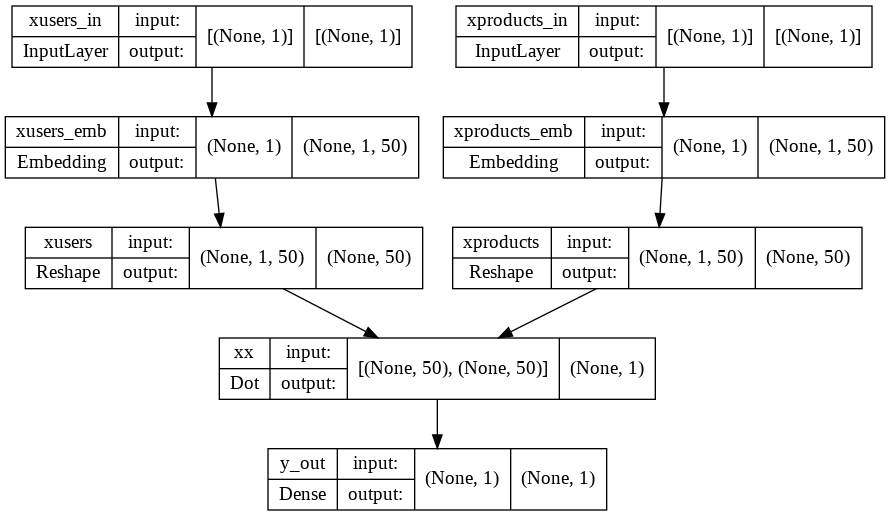

In [ ]:
utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
'''
Plot loss and metrics of keras training.
'''
def utils_plot_keras_training(training):
    metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,3))
    
    ## training
    ax[0].set(title="Training")
    ax11 = ax[0].twinx()
    ax[0].plot(training.history['loss'], color='black')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax11.plot(training.history[metric], label=metric)
    ax11.set_ylabel("Score", color='steelblue')
    ax11.legend()
    
    ## validation
    ax[1].set(title="Validation")
    ax22 = ax[1].twinx()
    ax[1].plot(training.history['val_loss'], color='black')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax22.plot(training.history['val_'+metric], label=metric)
    ax22.set_ylabel("Score", color="steelblue")
    plt.show()

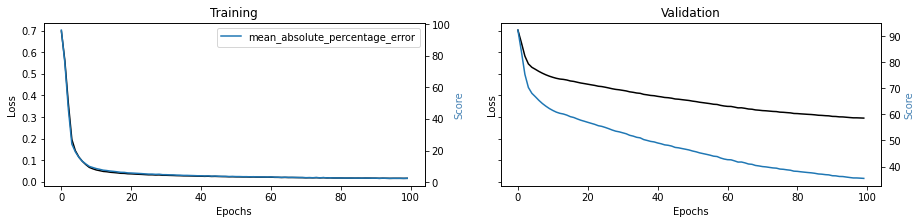

In [ ]:
# train
training = model.fit(x=[train["user"], train["product"]], y=train["y"], 
                     epochs=100, batch_size=128, shuffle=True, verbose=0, validation_split=0.3)
model = training.model
utils_plot_keras_training(training)

In [ ]:
# test
test["yhat"] = model.predict([test["user"], test["product"]])
test

,user,product,y,yhat
0,1,8063,0.812500,0.469682
1,1,8305,1.000000,0.461214
2,1,8376,0.777778,0.440867
3,1,8466,0.800000,0.461914
4,1,8509,0.500000,0.377028
...,...,...,...,...
666,64,8023,0.500000,0.599606
667,64,8376,0.944444,0.594650
668,64,8438,0.666667,0.604938
669,64,8569,0.900000,0.638015


In [ ]:
# overall
y_test = test["y"]
predicted = test["yhat"]

print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.0f}".format(metrics.mean_absolute_error(y_test, predicted)))
print("Mean Absolute Perc Error (Σ(|y-pred|/y)/n):", str(round(np.mean(np.abs((y_test-predicted)/predicted)), 2))+"%")

Mean Absolute Error (Σ|y-pred|/n): 0
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.62%


In [ ]:
# single case
i = 1
print("--- user", i, "---")

top = 5
y_test = test[test["user"]==i].sort_values("y", ascending=False)["product"].values[:top]
print("y_test:", y_test)

predicted = test[test["user"]==i].sort_values("yhat", ascending=False)["product"].values[:top]
print("predicted:", predicted)

true_positive = len(list(set(y_test) & set(predicted)))
print("true positive:", true_positive, "("+str(round(true_positive/top*100,1))+"%)")
print("accuracy:", str(round(metrics.accuracy_score(y_test,predicted)*100,1))+"%")
print("mrr:", round(mean_reciprocal_rank(y_test, predicted),2))

--- user 1 ---
y_test: [8305 8681 8550 8063 8466]
predicted: [8681 8063 8466 8305 8376]
true positive: 4 (80.0%)
accuracy: 0.0%
mrr: 0.42


In [ ]:
test[test["user"]==i].merge(
        dtf_products[["name","old","genres"]], left_on="product", right_index=True
    ).sort_values("yhat", ascending=False)

,user,product,y,yhat,name,old,genres
6,1,8681,1.000000,0.551123,Mad Max: Fury Road,0,Action|Adventure|Sci-Fi|Thriller
0,1,8063,0.812500,0.469682,Django Unchained,0,Action|Drama|Western
3,1,8466,0.800000,0.461914,Whiplash,0,Drama
1,1,8305,1.000000,0.461214,"Wolf of Wall Street, The",0,Comedy|Crime|Drama
2,1,8376,0.777778,0.440867,Interstellar,0,Sci-Fi|IMAX
5,1,8550,0.875000,0.383516,Ex Machina,0,Drama|Sci-Fi|Thriller
4,1,8509,0.500000,0.377028,The Drop,0,Crime|Drama|Thriller
7,1,8828,0.500000,0.375566,The Jinx: The Life and Deaths of Robert Durst,0,Documentary


# 5 - Model Desing & Testing (Neural Collaborative Filtering)

Actualmente, todos los sistemas de recomendación de última generación aprovechan el aprendizaje profundo. En particular, el filtrado colaborativo neuronal (2017) combina la no linealidad de las redes neuronales y la factorización matricial. El modelo está diseñado para aprovechar al máximo el espacio de incrustación usándolo no solo para el filtrado colaborativo tradicional, sino también para una red neuronal profunda totalmente conectada. La parte adicional debe capturar patrones y características que la factorización de matriz podría pasar por alto.

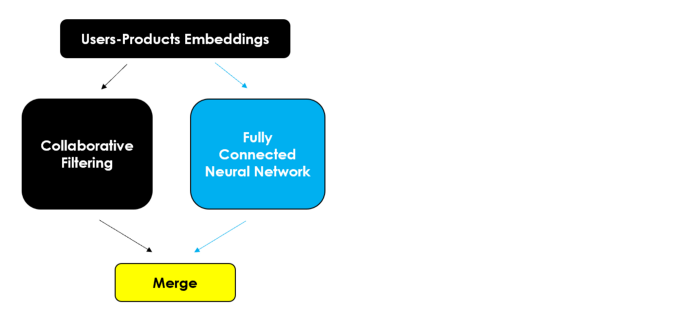

In [ ]:
train = dtf_train.stack(dropna=True).reset_index().rename(columns={0:"y"})
train.head()

,user,product,y
0,0,0,0.80
1,0,2,0.75
2,0,5,0.75
3,0,43,1.00
4,0,46,1.00


In [ ]:
test = dtf_test.stack(dropna=True).reset_index().rename(columns={0:"y"})
test.head()

,user,product,y
0,1,8063,0.812500
1,1,8305,1.000000
2,1,8376,0.777778
3,1,8466,0.800000
4,1,8509,0.500000


In [ ]:
embeddings_size = 50
usr, prd = dtf_users.shape[0], dtf_users.shape[1]

# Input layer
xusers_in = layers.Input(name="xusers_in", shape=(1,))
xproducts_in = layers.Input(name="xproducts_in", shape=(1,))

# A) Matrix Factorization
## embeddings and reshape
cf_xusers_emb = layers.Embedding(name="cf_xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
cf_xusers = layers.Reshape(name='cf_xusers', target_shape=(embeddings_size,))(cf_xusers_emb)
## embeddings and reshape
cf_xproducts_emb = layers.Embedding(name="cf_xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
cf_xproducts = layers.Reshape(name='cf_xproducts', target_shape=(embeddings_size,))(cf_xproducts_emb)
## product
cf_xx = layers.Dot(name='cf_xx', normalize=True, axes=1)([cf_xusers, cf_xproducts])

# B) Neural Network
## embeddings and reshape
nn_xusers_emb = layers.Embedding(name="nn_xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
nn_xusers = layers.Reshape(name='nn_xusers', target_shape=(embeddings_size,))(nn_xusers_emb)
## embeddings and reshape
nn_xproducts_emb = layers.Embedding(name="nn_xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
nn_xproducts = layers.Reshape(name='nn_xproducts', target_shape=(embeddings_size,))(nn_xproducts_emb)
## concat and dense
nn_xx = layers.Concatenate()([nn_xusers, nn_xproducts])
nn_xx = layers.Dense(name="nn_xx", units=int(embeddings_size/2), activation='relu')(nn_xx)

# Merge A & B
y_out = layers.Concatenate()([cf_xx, nn_xx])
y_out = layers.Dense(name="y_out", units=1, activation='linear')(y_out)

# Compile
model = models.Model(inputs=[xusers_in,xproducts_in], outputs=y_out, name="Neural_CollaborativeFiltering")
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_percentage_error'])
model.summary()

Model: "Neural_CollaborativeFiltering"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 xusers_in (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 xproducts_in (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 nn_xusers_emb (Embedding)      (None, 1, 50)        3300        ['xusers_in[0][0]']              
                                                                                                  
 nn_xproducts_emb (Embedding)   (None, 1, 50)        487050      ['xproducts_in[0][0]']           
                                                                      

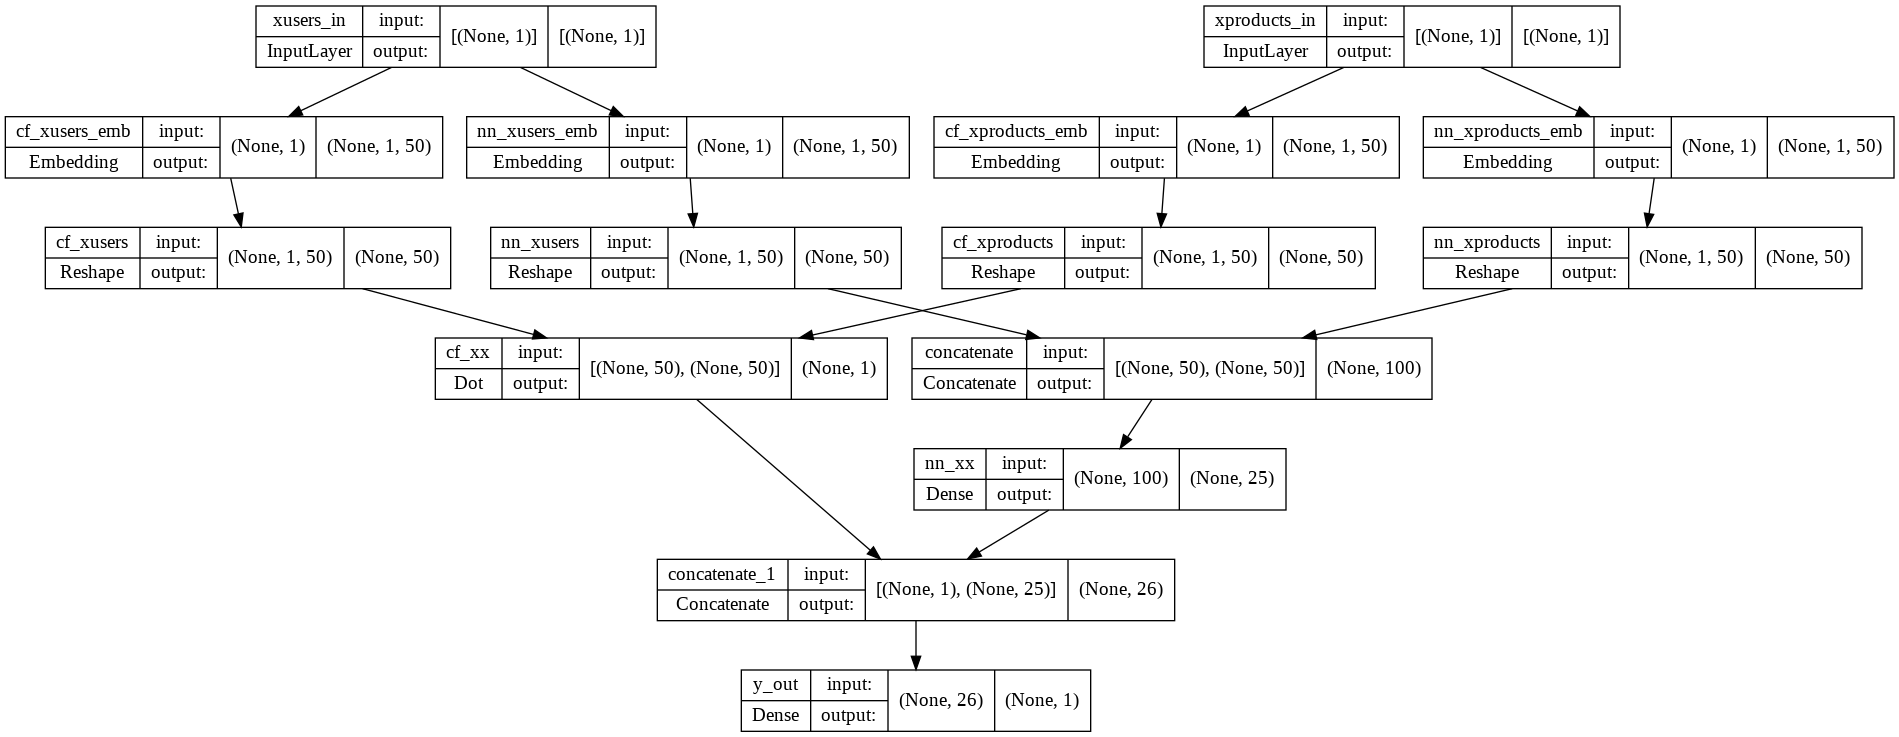

In [ ]:
utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

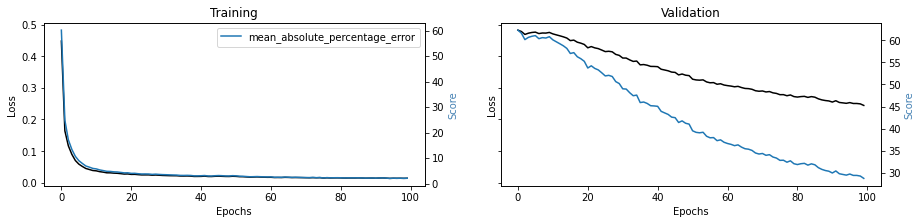

In [ ]:
# train
training = model.fit(x=[train["user"], train["product"]], y=train["y"], 
                     epochs=100, batch_size=128, shuffle=True, verbose=0, validation_split=0.3)
model = training.model
utils_plot_keras_training(training)

In [ ]:
# test
test["yhat"] = model.predict([test["user"], test["product"]])
test

,user,product,y,yhat
0,1,8063,0.812500,0.729032
1,1,8305,1.000000,0.634380
2,1,8376,0.777778,0.588845
3,1,8466,0.800000,0.743197
4,1,8509,0.500000,0.705303
...,...,...,...,...
666,64,8023,0.500000,0.515135
667,64,8376,0.944444,0.451250
668,64,8438,0.666667,0.559314
669,64,8569,0.900000,0.600325


In [ ]:
# overall
y_test = test["y"]
predicted = test["yhat"]

print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.0f}".format(metrics.mean_absolute_error(y_test, predicted)))
print("Mean Absolute Perc Error (Σ(|y-pred|/y)/n):", str(round(np.mean(np.abs((y_test-predicted)/predicted)), 2))+"%")

Mean Absolute Error (Σ|y-pred|/n): 0
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.31%


In [ ]:
# single case
i = 1
print("--- user", i, "---")

top = 5
y_test = test[test["user"]==i].sort_values("y", ascending=False)["product"].values[:top]
print("y_test:", y_test)

predicted = test[test["user"]==i].sort_values("yhat", ascending=False)["product"].values[:top]
print("predicted:", predicted)

true_positive = len(list(set(y_test) & set(predicted)))
print("true positive:", true_positive, "("+str(round(true_positive/top*100,1))+"%)")
print("accuracy:", str(round(metrics.accuracy_score(y_test,predicted)*100,1))+"%")
print("mrr:", round(mean_reciprocal_rank(y_test, predicted),2))

--- user 1 ---
y_test: [8305 8681 8550 8063 8466]
predicted: [8466 8063 8509 8828 8305]
true positive: 3 (60.0%)
accuracy: 0.0%
mrr: 0.34


In [ ]:
test[test["user"]==i].merge(
        dtf_products[["name","old","genres"]], left_on="product", right_index=True
    ).sort_values("yhat", ascending=False)

,user,product,y,yhat,name,old,genres
3,1,8466,0.800000,0.743197,Whiplash,0,Drama
0,1,8063,0.812500,0.729032,Django Unchained,0,Action|Drama|Western
4,1,8509,0.500000,0.705303,The Drop,0,Crime|Drama|Thriller
7,1,8828,0.500000,0.655595,The Jinx: The Life and Deaths of Robert Durst,0,Documentary
1,1,8305,1.000000,0.634380,"Wolf of Wall Street, The",0,Comedy|Crime|Drama
6,1,8681,1.000000,0.616673,Mad Max: Fury Road,0,Action|Adventure|Sci-Fi|Thriller
2,1,8376,0.777778,0.588845,Interstellar,0,Sci-Fi|IMAX
5,1,8550,0.875000,0.530249,Ex Machina,0,Drama|Sci-Fi|Thriller


# 6 - Hybrid Model

* Variable de destino : las calificaciones pueden ser explícitas (es decir, el usuario deja comentarios) o implícitas (es decir, asumir comentarios positivos si el usuario ve la película completa), de todos modos, son necesarios.
* Características del producto : etiquetas y descripciones de los elementos (es decir, géneros de películas), que se utilizan principalmente en los métodos basados ​​en el contenido.
* Perfil de usuario : la información descriptiva sobre los usuarios puede ser demográfica (es decir, sexo y edad) o conductual (es decir, preferencias, tiempo promedio en pantalla, tiempo de uso más frecuente), que se utiliza principalmente para recomendaciones basadas en conocimientos.
* Contexto : información adicional sobre la situación en torno a la calificación (es decir, cuándo, dónde, historial de búsqueda), que a menudo también se incluye en las recomendaciones basadas en el conocimiento.

In [ ]:
  # Extra data
features = dtf_products.drop(["genres","name"], axis=1).columns
print(features)

context = dtf_context.drop(["user","product"], axis=1).columns
print(context)

Index(['old', 'Crime', 'Animation', 'Romance', 'Comedy', 'Action', 'IMAX',
       'Thriller', 'Musical', 'Fantasy', 'Sci-Fi', 'Children', 'Western',
       'Horror', 'War', 'Adventure', 'Mystery', 'Film-Noir', 'Drama',
       'Documentary'],
      dtype='object')
Index(['daytime', 'weekend'], dtype='object')


In [ ]:
train = dtf_train.stack(dropna=True).reset_index().rename(columns={0:"y"})

## add features
train = train.merge(dtf_products[features], how="left", left_on="product", right_index=True)

## add context
train = train.merge(dtf_context, how="left")

train.head()

,user,product,y,old,Crime,Animation,Romance,Comedy,Action,IMAX,...,Western,Horror,War,Adventure,Mystery,Film-Noir,Drama,Documentary,daytime,weekend
0,0,0,0.80,1,0,1,0,1,0,0,...,0,0,0,1,0,0,0,0,1,1
1,0,2,0.75,1,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,1,1
2,0,5,0.75,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,1
3,0,43,1.00,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,1
4,0,46,1.00,1,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,1


Ahora tenemos todos los ingredientes para construir un modelo híbrido consciente del contexto . La flexibilidad de las redes neuronales nos permite agregar lo que queramos, así que tomaré la estructura de red de filtrado colaborativo neuronal e incluiré tantos módulos como sea posible.

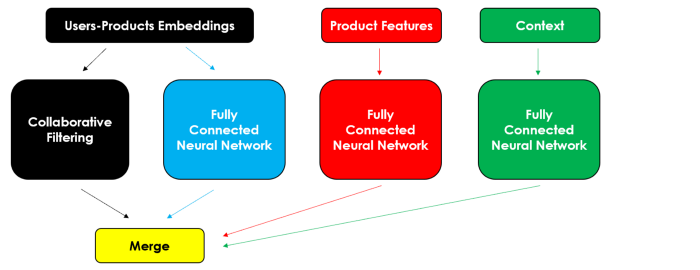

In [ ]:
embeddings_size = 50
usr, prd = dtf_users.shape[0], dtf_users.shape[1]
feat = len(features)
ctx = len(context)

########################################## COLLABORATIVE FILTERING ###################################################
# Input layer
xusers_in = layers.Input(name="xusers_in", shape=(1,))
xproducts_in = layers.Input(name="xproducts_in", shape=(1,))

# A) Matrix Factorization
## embeddings and reshape
cf_xusers_emb = layers.Embedding(name="cf_xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
cf_xusers = layers.Reshape(name='cf_xusers', target_shape=(embeddings_size,))(cf_xusers_emb)
## embeddings and reshape
cf_xproducts_emb = layers.Embedding(name="cf_xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
cf_xproducts = layers.Reshape(name='cf_xproducts', target_shape=(embeddings_size,))(cf_xproducts_emb)
## product
cf_xx = layers.Dot(name='cf_xx', normalize=True, axes=1)([cf_xusers, cf_xproducts])

# B) Neural Network
## embeddings and reshape
nn_xusers_emb = layers.Embedding(name="nn_xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
nn_xusers = layers.Reshape(name='nn_xusers', target_shape=(embeddings_size,))(nn_xusers_emb)
## embeddings and reshape
nn_xproducts_emb = layers.Embedding(name="nn_xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
nn_xproducts = layers.Reshape(name='nn_xproducts', target_shape=(embeddings_size,))(nn_xproducts_emb)
## concat and dense
nn_xx = layers.Concatenate()([nn_xusers, nn_xproducts])
nn_xx = layers.Dense(name="nn_xx", units=int(embeddings_size/2), activation='relu')(nn_xx)

########################################## CONTENT BASED ###################################################
# Product Features
features_in = layers.Input(name="features_in", shape=(feat,))
features_x = layers.Dense(name="features_x", units=feat, activation='relu')(features_in)

########################################## KNOWLEDGE BASED #################################################
# Context
contexts_in = layers.Input(name="contexts_in", shape=(ctx,))
context_x = layers.Dense(name="context_x", units=ctx, activation='relu')(contexts_in)

########################################## OUTPUT ###################################################
# Merge all
y_out = layers.Concatenate()([cf_xx, nn_xx, features_x, context_x])
y_out = layers.Dense(name="y_out", units=1, activation='linear')(y_out)

# Compile
model = models.Model(inputs=[xusers_in,xproducts_in, features_in, contexts_in], outputs=y_out, name="Hybrid_Model")
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_percentage_error'])
model.summary()

Model: "Hybrid_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 xusers_in (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 xproducts_in (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 nn_xusers_emb (Embedding)      (None, 1, 50)        3300        ['xusers_in[0][0]']              
                                                                                                  
 nn_xproducts_emb (Embedding)   (None, 1, 50)        487050      ['xproducts_in[0][0]']           
                                                                                       

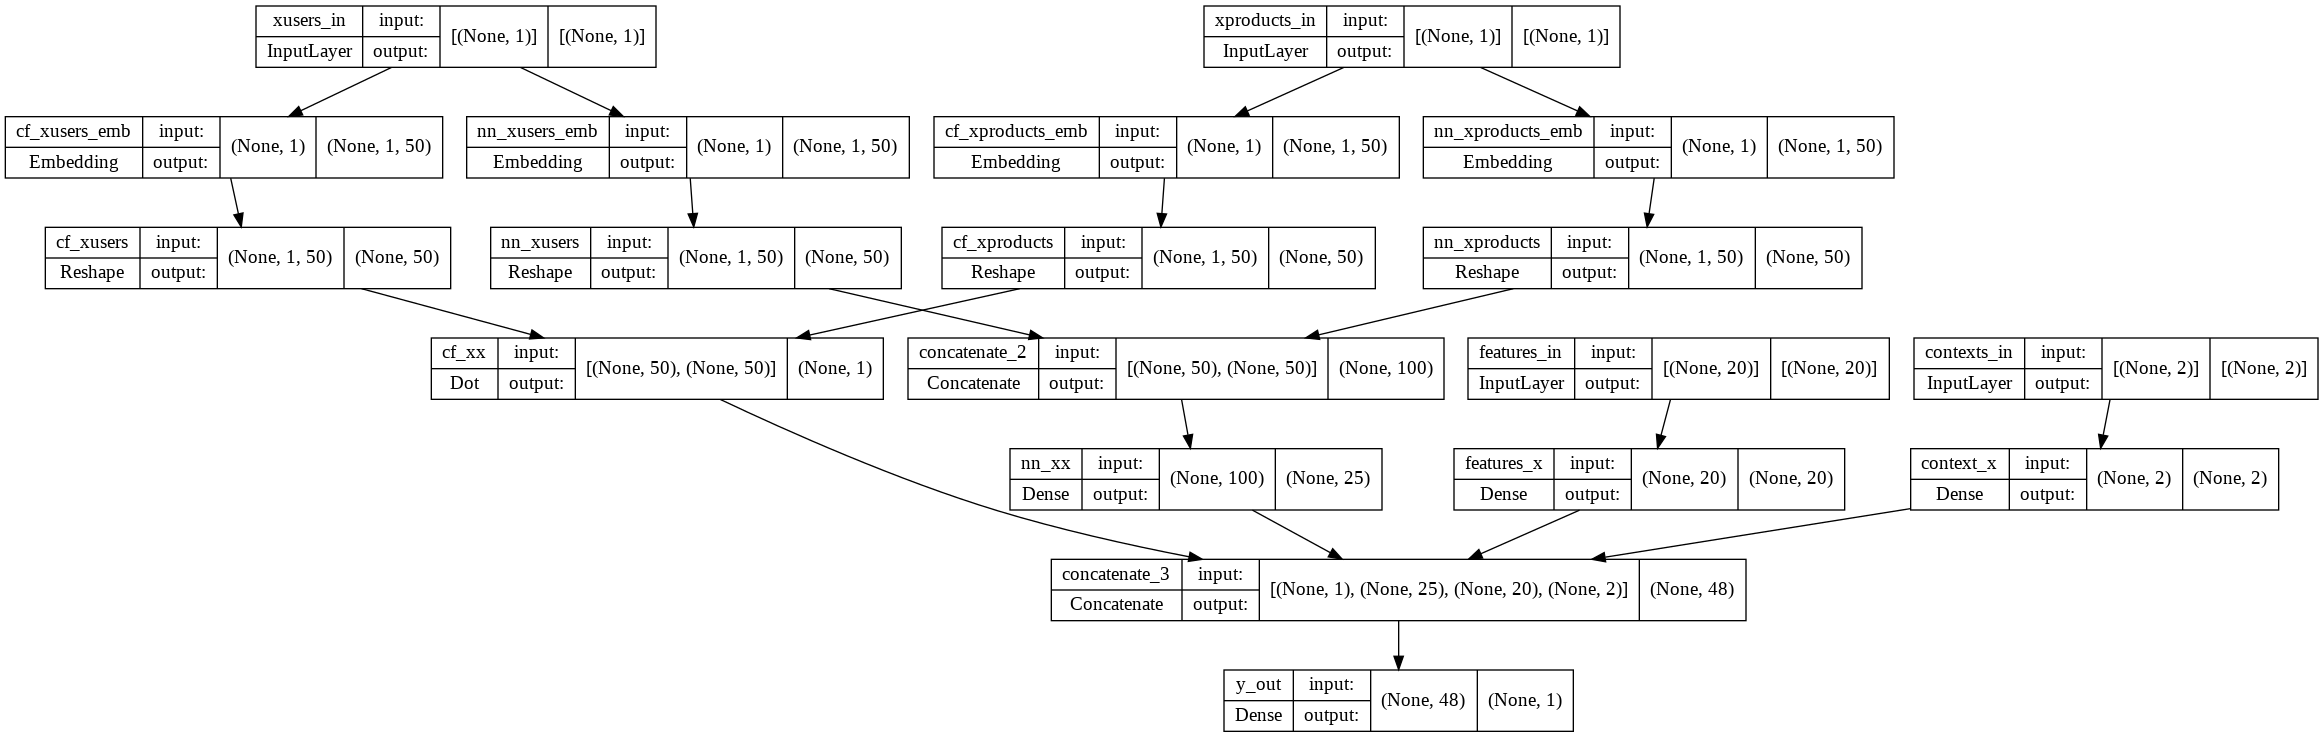

In [ ]:
utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
# train
training = model.fit(x=[train["user"], train["product"], train[features], train[context]], y=train["y"], 
                     epochs=100, batch_size=128, shuffle=True, verbose=0, validation_split=0.3)

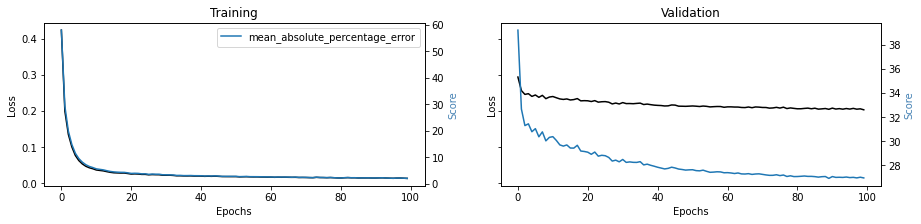

In [ ]:
model = training.model
utils_plot_keras_training(training)

In [ ]:
# test
test["yhat"] = model.predict([test["user"], test["product"], test[features], test[context]])
test